# Entrenando un modelo de IA usando datos EMG

In [1]:
# Importar las librerias necesaria
import pandas as pd
import numpy as np
import os
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras.layers import Input, Dense, Dropout
import sklearn
from sklearn.metrics import confusion_matrix
from tensorflow import lite

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [252]:
# Nombre de los sensores empleados.
emg_columns = ["EMG1", "EMG2", "IR", "RED"]

# Asignar a cada carpeta un identificador correspondiente a una tarea motora.
FOLDER_2_LABEL = {"task1": 0, "task2": 1, "task3": 2} #, "task4": 3

# Frecuencia de Muestreo de la señal.
ORIGINAL_FREC = 100 # Hz
# Tiempo de muestreo de un sample.
SAMPLE_TIME = 5
TOTAL_DATA = int(SAMPLE_TIME*ORIGINAL_FREC)

# Path donde se almacenan los datos.
MAIN_PATH = "/content/drive/MyDrive/Colab Notebooks/Tesis/Dataset"

# Path para guardar las características calculadas.
FEATURES_PATH = "Features.csv"

In [239]:
def filter_signal(df: pd.DataFrame, window_size: int):
    """
    Filtrar la señal usando el método de la media móvil.
    Params:
        df: contiene los datos emg, siendo
            cada columna el registro de un
            sensor. 
        window_size: tamano de la ventana móvil.
    Return:
        df_filtered (Dataframe): contiene los datos EMG 
                                 filtrados por columna.
    """
    df_filtered = df.rolling(window_size).mean()
    df_filtered.dropna(inplace=True)
    return df_filtered

def normalize_columns(df: pd.DataFrame):
    """
    Normalizar las columnas aplicando el 
    método de normalización min-max.
    """
    df_normalized = (df-df.min())/(df.max()-df.min())
    return df_normalized

def calculate_features(df: pd.DataFrame, label: int):
    """
    Calcula las características de la señal por sensor,
    usando el método del valor RMS.
    Params:
        df: contiene los datos emg, siendo
            cada columna el registro de un
            sensor.
        label: el identificador de la tarea motora a
               la que corresponde esa señal.
    Return:
        features_list (list): contiene el label de la
                              señal y las características. 
    """
    features_list = []
    for sensor in emg_columns:
        for i in range(0, 500, 100):
            features_list.append(np.sqrt(np.mean(df.iloc[i:i+50][sensor]**2)))
    features_list.insert(0, label)
    return features_list

## Filtrado - Normalización - Extracción de características

Nota: Para calcular y usar el valor RMS de una senal como entrada de un modelo, se debe procurar escoger una ventana no tan grande, ya que la senal podría dejar de ser representativa.

In [253]:
# El tamano de la ventana para calcular las características.
WINDOW_RMS = 100

# El tamano de la ventana inicial debe ser divisible para el tamano de la ventana RMS.
assert(TOTAL_DATA % WINDOW_RMS == 0)

# Generar una lista que contenga los nombres de las características a calcular.
features_column = ['RMS' + str(x) + '_' + sensor for sensor in emg_columns for x in range(WINDOW_RMS,TOTAL_DATA+WINDOW_RMS, WINDOW_RMS)]
features_column.insert(0,"Label")

# Inicializar el Dataframe que contendrá las características calculadas más adelante.
df_features = pd.DataFrame(columns=features_column)

In [254]:
df_features

,Label,RMS100_EMG1,RMS200_EMG1,RMS300_EMG1,RMS400_EMG1,RMS500_EMG1,RMS100_EMG2,RMS200_EMG2,RMS300_EMG2,RMS400_EMG2,...,RMS100_IR,RMS200_IR,RMS300_IR,RMS400_IR,RMS500_IR,RMS100_RED,RMS200_RED,RMS300_RED,RMS400_RED,RMS500_RED


In [255]:
# Recorrer cada carpeta.
for folder in os.listdir(MAIN_PATH):
    folder_path = os.path.join(MAIN_PATH, folder)
    # Recorrer cada archivo de la carpeta.
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        # Leer las señales de los sensores.
        df = pd.read_csv(file_path, names=emg_columns, index_col=False)
        # Filtrar las señales de los sensores.
        df_filtered = filter_signal(df, 2)
        # Normalizar las señales de los sensores.
        df_norm = normalize_columns(df_filtered)
        # Calcular las características del respectivo archivo.
        if str(file)[3] != '3':
          features = calculate_features(df_norm, str(file)[3])
          # Agregar las características calculadas al Dataframe df_features.
          df_features.loc[len(df_features)] = features

In [256]:
df_features

,Label,RMS100_EMG1,RMS200_EMG1,RMS300_EMG1,RMS400_EMG1,RMS500_EMG1,RMS100_EMG2,RMS200_EMG2,RMS300_EMG2,RMS400_EMG2,...,RMS100_IR,RMS200_IR,RMS300_IR,RMS400_IR,RMS500_IR,RMS100_RED,RMS200_RED,RMS300_RED,RMS400_RED,RMS500_RED
0,0,0.401059,0.322984,0.311375,0.311155,0.315790,0.403152,0.306009,0.296639,0.299124,...,0.390489,0.509156,0.541187,0.539595,0.515845,0.377857,0.464574,0.497231,0.504410,0.509788
1,0,0.239954,0.239260,0.233679,0.243365,0.220864,0.264774,0.256589,0.260338,0.265014,...,0.494487,0.457023,0.532595,0.477934,0.459101,0.482642,0.465549,0.503634,0.483163,0.486261
2,0,0.445401,0.402487,0.405470,0.379263,0.388726,0.357488,0.301778,0.308334,0.299460,...,0.471304,0.481071,0.484152,0.452304,0.434112,0.462195,0.439080,0.449801,0.436976,0.441353
3,1,0.314652,0.232033,0.187766,0.145753,0.153840,0.386271,0.294473,0.218935,0.143164,...,0.718759,0.269880,0.106408,0.046560,0.021568,0.651877,0.258034,0.061836,0.070599,0.053431
4,0,0.472759,0.422699,0.393336,0.380729,0.391731,0.385343,0.315504,0.292769,0.280093,...,0.479594,0.872416,0.964717,0.986341,0.948819,0.453520,0.674296,0.751216,0.745813,0.567132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2,0.349735,0.240428,0.146069,0.170874,0.144680,0.361745,0.216168,0.157946,0.213604,...,0.444111,0.056788,0.041131,0.024194,0.004711,0.445500,0.064169,0.040104,0.036768,0.020459
296,2,0.150511,0.105203,0.050905,0.056296,0.213938,0.201838,0.138670,0.084536,0.088891,...,0.191588,0.036058,0.021067,0.021497,0.019963,0.242084,0.119590,0.103661,0.111189,0.198854
297,2,0.229248,0.193848,0.264769,0.161174,0.143069,0.250212,0.185321,0.250738,0.175128,...,0.239651,0.119239,0.112262,0.103284,0.095679,0.246351,0.162653,0.156786,0.139452,0.140423
298,2,0.236795,0.327813,0.184194,0.163479,0.209075,0.235688,0.339608,0.221054,0.198341,...,0.594820,0.936006,0.598103,0.232597,0.134177,0.615930,0.912916,0.522733,0.259777,0.263575


In [210]:
# Se almacenan todas las columnas excepto la columna de etiqueta de tareas 
featureR = df_features[df_features.columns[1:]]

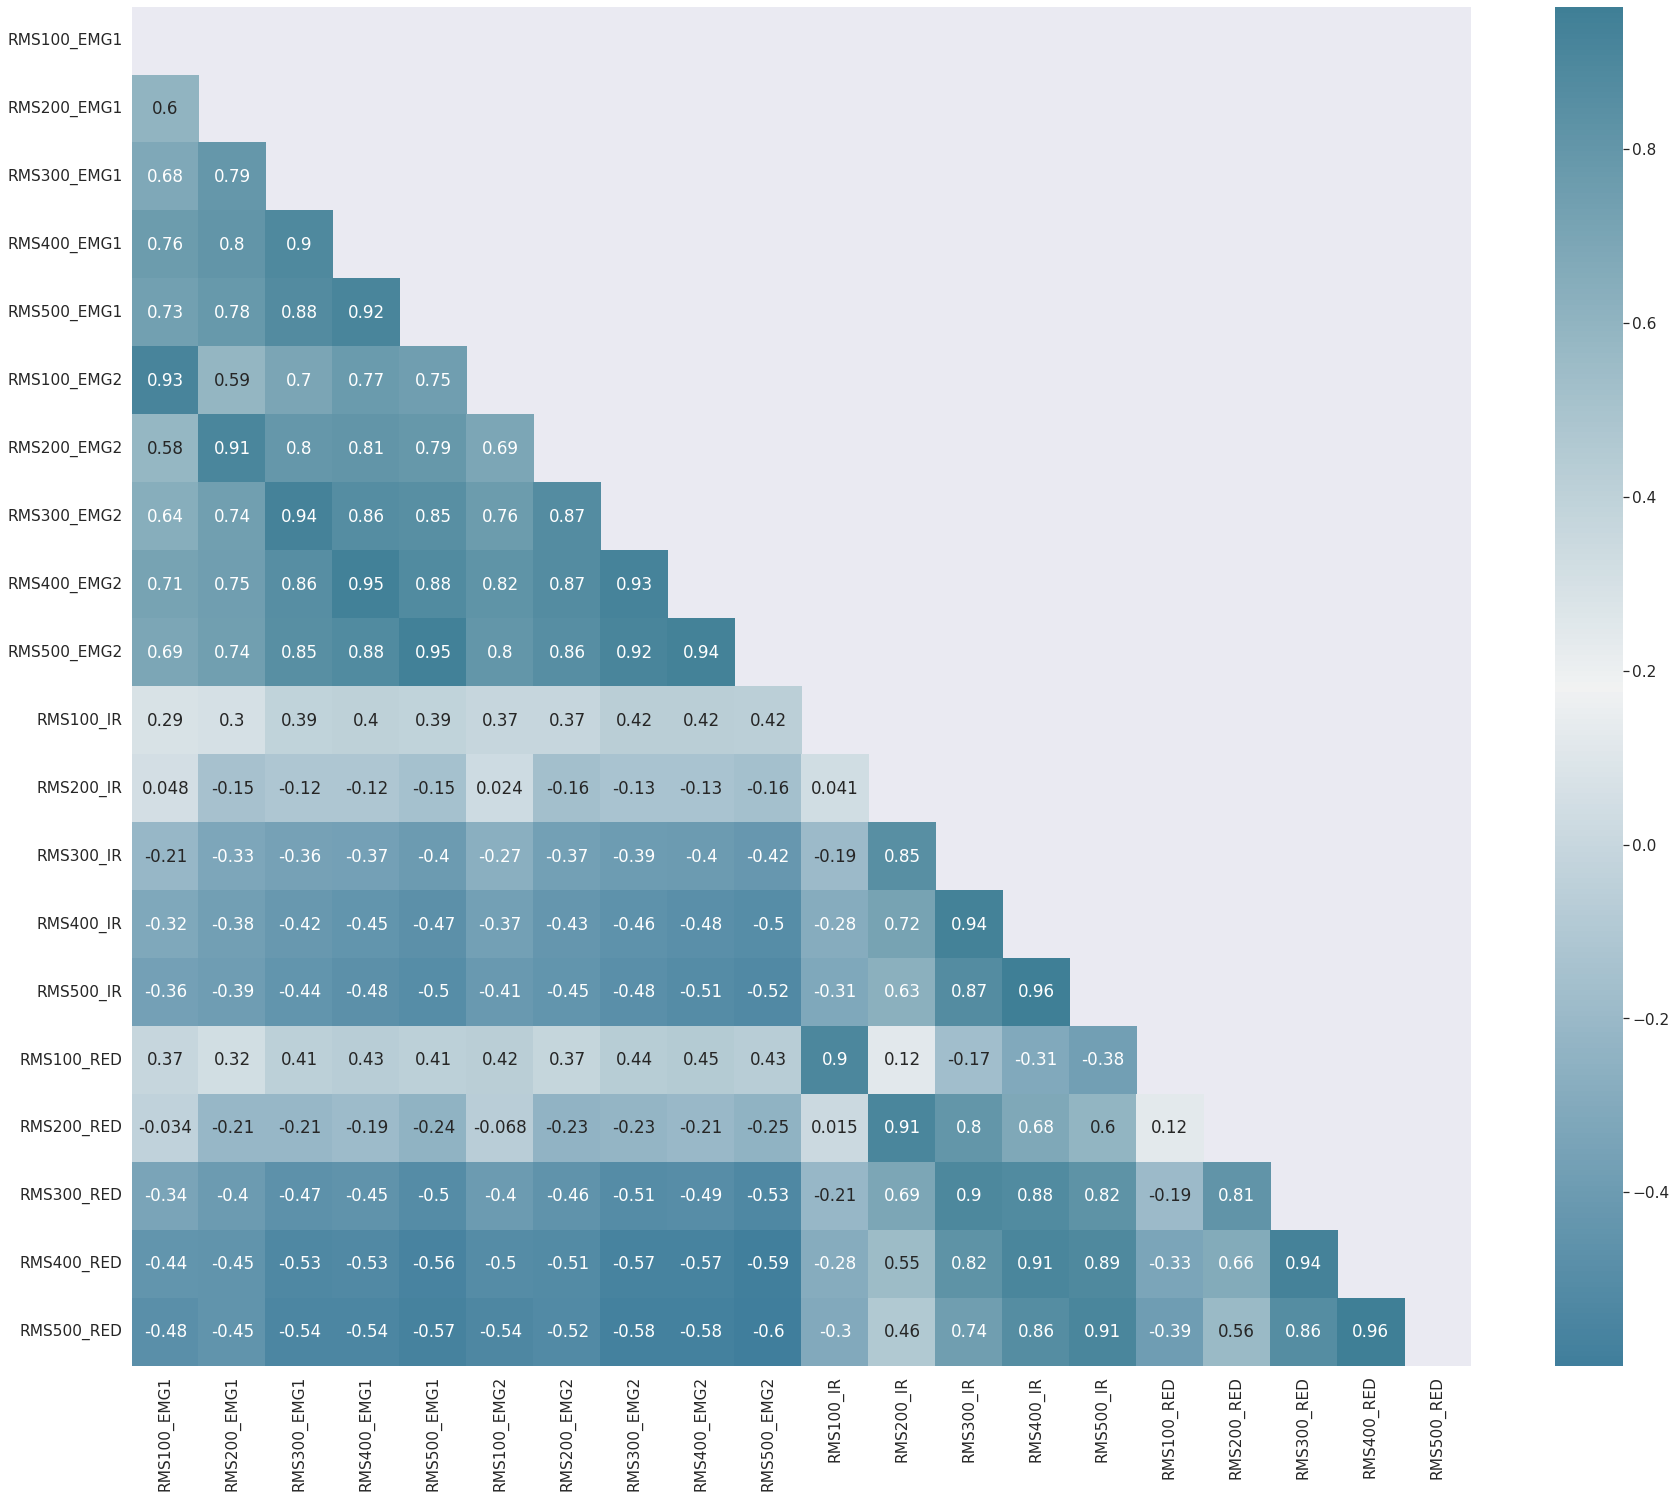

In [211]:
# Correlación entre diferentes variables
#
corr = featureR.corr()
#
# Configuración para gráfico con matplotlib
#
f, ax = plt.subplots(figsize=(30, 25))
#
# Generar triangulo superior
#
mask = np.triu(np.ones_like(corr, dtype=bool))
#
# Configurar mapa de correlación
#
cmap = sn.diverging_palette(230, 224, as_cmap=True)
#
# Dibujar mapa de correlación
#
sn.heatmap(corr, annot=True, mask = mask, cmap=cmap)

In [165]:
# Se selecciona el triangulo superior
upper_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))

<ipython-input-165-b3f1657fed45>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))


In [212]:
# Se eliminan las columnas con una correlación mayor a 0.75
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(to_drop)

['RMS500_IR', 'RMS500_RED']


In [213]:
df_featuresDC = df_features.drop(to_drop, axis=1)

In [214]:
df_featuresDC

,Label,RMS100_EMG1,RMS200_EMG1,RMS300_EMG1,RMS400_EMG1,RMS500_EMG1,RMS100_EMG2,RMS200_EMG2,RMS300_EMG2,RMS400_EMG2,RMS500_EMG2,RMS100_IR,RMS200_IR,RMS300_IR,RMS400_IR,RMS100_RED,RMS200_RED,RMS300_RED,RMS400_RED
0,3,0.207239,0.184037,0.195437,0.219213,0.186671,0.193127,0.177874,0.206028,0.201422,0.166203,0.576775,0.834509,0.878617,0.912681,0.732742,0.944644,0.938772,0.886560
1,0,0.401059,0.322984,0.311375,0.311155,0.315790,0.403152,0.306009,0.296639,0.299124,0.304453,0.390489,0.509156,0.541187,0.539595,0.377857,0.464574,0.497231,0.504410
2,3,0.257750,0.255839,0.087063,0.069540,0.072518,0.257797,0.253666,0.086404,0.071695,0.080234,0.758371,0.928773,0.765080,0.556263,0.797545,0.920571,0.841202,0.736296
3,0,0.239954,0.239260,0.233679,0.243365,0.220864,0.264774,0.256589,0.260338,0.265014,0.251389,0.494487,0.457023,0.532595,0.477934,0.482642,0.465549,0.503634,0.483163
4,3,0.264705,0.290104,0.144716,0.175693,0.097641,0.264254,0.308859,0.155267,0.164701,0.092988,0.533508,0.845964,0.892689,0.868842,0.633578,0.927305,0.952938,0.914604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,2,0.229248,0.193848,0.264769,0.161174,0.143069,0.250212,0.185321,0.250738,0.175128,0.152292,0.239651,0.119239,0.112262,0.103284,0.246351,0.162653,0.156786,0.139452
396,3,0.280041,0.178945,0.120766,0.145952,0.123981,0.343154,0.258512,0.172888,0.220721,0.183376,0.552656,0.455138,0.440909,0.335209,0.523809,0.508973,0.492048,0.374349
397,2,0.236795,0.327813,0.184194,0.163479,0.209075,0.235688,0.339608,0.221054,0.198341,0.209771,0.594820,0.936006,0.598103,0.232597,0.615930,0.912916,0.522733,0.259777
398,3,0.185748,0.001098,0.000622,0.000362,0.000449,0.291770,0.001525,0.001060,0.000630,0.000749,0.876855,0.990205,0.989146,0.989625,0.867554,0.980945,0.981711,0.980880


In [257]:
# Escribir el Dataframe con las características.
df_features.to_csv(FEATURES_PATH, index=False)

## Entrenamiento del modelo

In [329]:
# Definir una semilla.
RANDOM_STATE = 42

# Establecer el porcentaje para dividir la data.
TRAIN_SPLIT = 0.75
VALID_TEST_SPLIT = 0.125
assert(TRAIN_SPLIT + (2*VALID_TEST_SPLIT) == 1)

# Definir la taza de aprendizaje.
LEARNING_RATE = 0.0005

# Definir el número de épocas.
EPOCHS = 200

# Definir el tamaño del batch.
BATCH_SIZE = 30

In [330]:
# Leer archivo con características de las señales EMG.
features_df = pd.read_csv(FEATURES_PATH)

In [331]:
features_df

,Label,RMS100_EMG1,RMS200_EMG1,RMS300_EMG1,RMS400_EMG1,RMS500_EMG1,RMS100_EMG2,RMS200_EMG2,RMS300_EMG2,RMS400_EMG2,...,RMS100_IR,RMS200_IR,RMS300_IR,RMS400_IR,RMS500_IR,RMS100_RED,RMS200_RED,RMS300_RED,RMS400_RED,RMS500_RED
0,0,0.401059,0.322984,0.311375,0.311155,0.315790,0.403152,0.306009,0.296639,0.299124,...,0.390489,0.509156,0.541187,0.539595,0.515845,0.377857,0.464574,0.497231,0.504410,0.509788
1,0,0.239954,0.239260,0.233679,0.243365,0.220864,0.264774,0.256589,0.260338,0.265014,...,0.494487,0.457023,0.532595,0.477934,0.459101,0.482642,0.465549,0.503634,0.483163,0.486261
2,0,0.445401,0.402487,0.405470,0.379263,0.388726,0.357488,0.301778,0.308334,0.299460,...,0.471304,0.481071,0.484152,0.452304,0.434112,0.462195,0.439080,0.449801,0.436976,0.441353
3,1,0.314652,0.232033,0.187766,0.145753,0.153840,0.386271,0.294473,0.218935,0.143164,...,0.718759,0.269880,0.106408,0.046560,0.021568,0.651877,0.258034,0.061836,0.070599,0.053431
4,0,0.472759,0.422699,0.393336,0.380729,0.391731,0.385343,0.315504,0.292769,0.280093,...,0.479594,0.872416,0.964717,0.986341,0.948819,0.453520,0.674296,0.751216,0.745813,0.567132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2,0.349735,0.240428,0.146069,0.170874,0.144680,0.361745,0.216168,0.157946,0.213604,...,0.444111,0.056788,0.041131,0.024194,0.004711,0.445500,0.064169,0.040104,0.036768,0.020459
296,2,0.150511,0.105203,0.050905,0.056296,0.213938,0.201838,0.138670,0.084536,0.088891,...,0.191588,0.036058,0.021067,0.021497,0.019963,0.242084,0.119590,0.103661,0.111189,0.198854
297,2,0.229248,0.193848,0.264769,0.161174,0.143069,0.250212,0.185321,0.250738,0.175128,...,0.239651,0.119239,0.112262,0.103284,0.095679,0.246351,0.162653,0.156786,0.139452,0.140423
298,2,0.236795,0.327813,0.184194,0.163479,0.209075,0.235688,0.339608,0.221054,0.198341,...,0.594820,0.936006,0.598103,0.232597,0.134177,0.615930,0.912916,0.522733,0.259777,0.263575


In [332]:
# Convertir la columna a tipo int.
features_df["Label"] = features_df["Label"].astype(int)
# Asegurarnos de no introducir datos vacíos.
features_df.dropna(inplace=True)
# Hacer un shuffle a los datos.
features = features_df.sample(frac=1, random_state=RANDOM_STATE)
# Convertir a un arreglo de numpy (ya que el modelo trabaja con este tipo de datos).
features = features.to_numpy()

# Separar los datos entre el target (el id de la tarea motora) y las características.
# Nota: En este caso en específico se usa la función to_categorical, ya que 
# la función de pérdida que se usó en el modelo requiere de variables categóricas.
y_values = keras.utils.to_categorical(features[:,0], num_classes=3)
x_values = features[:,1:].astype('float32')

# Separar los datos en TRAINING, TESTING Y VALIDATION.
TRAIN_SPLIT =  int(TRAIN_SPLIT * features.shape[0])
TEST_SPLIT = int(VALID_TEST_SPLIT * features.shape[0] + TRAIN_SPLIT)
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Asegurar que la división de los datos fue exitosa.
assert(x_train.shape[0] + x_test.shape[0] + x_validate.shape[0] == features.shape[0])

###3

In [346]:
#Modelo 3
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D
from keras.optimizers import SGD


In [352]:
model = Sequential()
model.add(Dense(100, input_shape = (x_train.shape[1],), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(80, input_shape = (x_train.shape[1],), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(60, input_shape = (x_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(20))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(3))
model.add(Activation('softmax'))

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])


In [353]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_70 (Dense)            (None, 100)               2100      
                                                                 
 dropout_56 (Dropout)        (None, 100)               0         
                                                                 
 dense_71 (Dense)            (None, 80)                8080      
                                                                 
 dropout_57 (Dropout)        (None, 80)                0         
                                                                 
 dense_72 (Dense)            (None, 60)                4860      
                                                                 
 activation_42 (Activation)  (None, 60)                0         
                                                                 
 dropout_58 (Dropout)        (None, 60)              

###PEARSON

In [ ]:
%matplotlib inline
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('colorblind')

In [ ]:
x = np.random.normal(size=1000)
y = np.random.normal(loc=x, scale=1) 

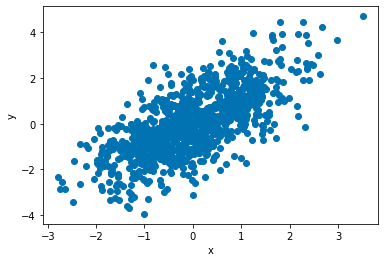

In [ ]:
plt.scatter(x, y, alpha=1)
plt.xlabel('x')
plt.ylabel('y');

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


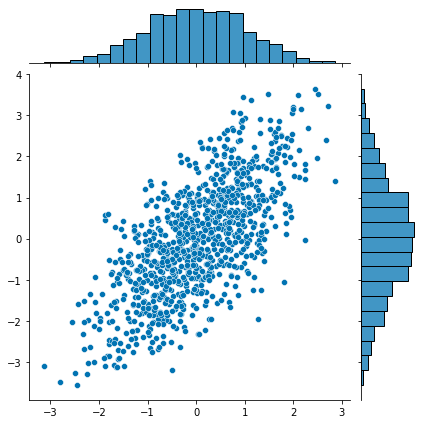

In [ ]:
sns.jointplot(x, y,  kind='scatter');

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


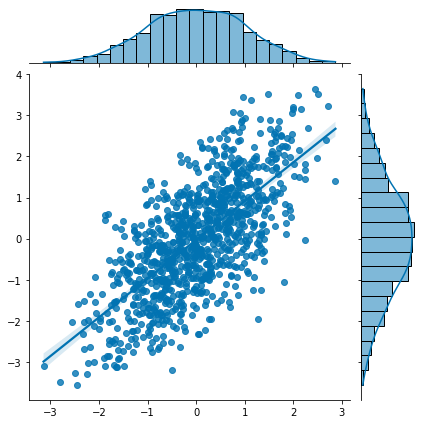

In [ ]:
sns.jointplot(x, y,  kind='reg');


In [ ]:
analisis = pd.read_csv("/content/Features.csv")
analisis.drop(columns="Label", inplace=True)
analisis.head()
analisis.to_csv("Features.csv")
pearson = analisis.corr(method="pearson")


In [ ]:
pearson

,RMS100_EMG1,RMS200_EMG1,RMS300_EMG1,RMS400_EMG1,RMS500_EMG1,RMS100_EMG2,RMS200_EMG2,RMS300_EMG2,RMS400_EMG2,RMS500_EMG2,RMS100_IR,RMS200_IR,RMS300_IR,RMS400_IR,RMS500_IR,RMS100_RED,RMS200_RED,RMS300_RED,RMS400_RED,RMS500_RED
RMS100_EMG1,1.000000,0.601005,0.679300,0.763362,0.734392,0.925672,0.579286,0.643039,0.713800,0.690833,0.287829,0.048225,-0.214142,-0.317333,-0.363939,0.365798,-0.033885,-0.341335,-0.444830,-0.479142
RMS200_EMG1,0.601005,1.000000,0.793823,0.804912,0.780378,0.587262,0.912835,0.741798,0.748558,0.738467,0.301829,-0.145476,-0.326826,-0.376278,-0.386360,0.319027,-0.210950,-0.402591,-0.448931,-0.448120
RMS300_EMG1,0.679300,0.793823,1.000000,0.895563,0.877871,0.695994,0.796148,0.937261,0.858105,0.847891,0.389419,-0.115970,-0.358845,-0.421997,-0.443726,0.410213,-0.210289,-0.471549,-0.528570,-0.539525
RMS400_EMG1,0.763362,0.804912,0.895563,1.000000,0.917727,0.771498,0.807029,0.861339,0.946171,0.881999,0.402163,-0.115774,-0.367579,-0.446918,-0.477590,0.428801,-0.185700,-0.454423,-0.525452,-0.544855
RMS500_EMG1,0.734392,0.780378,0.877871,0.917727,1.000000,0.747712,0.788773,0.851573,0.879935,0.949111,0.394254,-0.150475,-0.402746,-0.473879,-0.500746,0.411465,-0.240026,-0.503907,-0.562370,-0.572063
RMS100_EMG2,0.925672,0.587262,0.695994,0.771498,0.747712,1.000000,0.692014,0.763108,0.820564,0.799656,0.366022,0.024236,-0.265264,-0.371252,-0.413698,0.423004,-0.067909,-0.400060,-0.503921,-0.535166
RMS200_EMG2,0.579286,0.912835,0.796148,0.807029,0.788773,0.692014,1.000000,0.868192,0.867209,0.856492,0.366234,-0.162749,-0.373659,-0.433144,-0.445376,0.374909,-0.234015,-0.457963,-0.513583,-0.516897
RMS300_EMG2,0.643039,0.741798,0.937261,0.861339,0.851573,0.763108,0.868192,1.000000,0.927648,0.919878,0.423201,-0.133457,-0.392572,-0.460137,-0.479663,0.435500,-0.225060,-0.505035,-0.565439,-0.575436
RMS400_EMG2,0.713800,0.748558,0.858105,0.946171,0.879935,0.820564,0.867209,0.927648,1.000000,0.939100,0.424983,-0.133854,-0.399303,-0.481748,-0.507639,0.446662,-0.205031,-0.491068,-0.565020,-0.580757
RMS500_EMG2,0.690833,0.738467,0.847891,0.881999,0.949111,0.799656,0.856492,0.919878,0.939100,1.000000,0.415770,-0.158622,-0.424429,-0.499504,-0.522716,0.430619,-0.245260,-0.526634,-0.590516,-0.599850


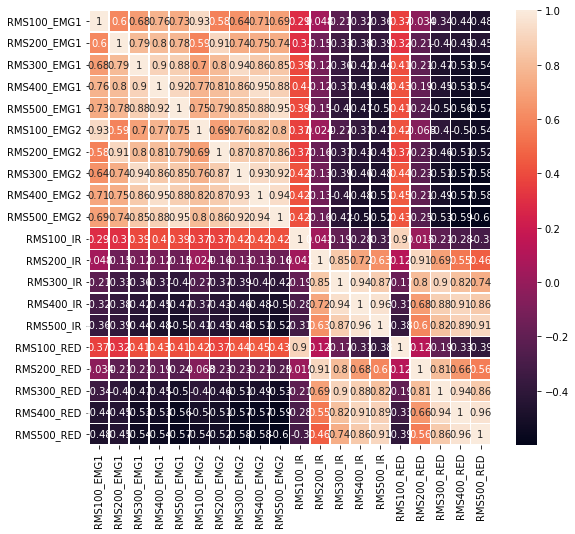

In [ ]:
plt.figure(figsize=(9,8))
sns.heatmap(pearson, 
            annot=True,
            linewidths=.5)

plt.show()

In [ ]:
orden = pearson.unstack()


In [ ]:
print(orden)


RMS100_EMG1  RMS100_EMG1    1.000000
             RMS200_EMG1    0.601005
             RMS300_EMG1    0.679300
             RMS400_EMG1    0.763362
             RMS500_EMG1    0.734392
                              ...   
RMS500_RED   RMS100_RED    -0.388053
             RMS200_RED     0.563845
             RMS300_RED     0.861415
             RMS400_RED     0.963410
             RMS500_RED     1.000000
Length: 400, dtype: float64


In [ ]:
orden = orden.sort_values()


In [ ]:
print(orden)


RMS500_EMG2  RMS500_RED    -0.599850
RMS500_RED   RMS500_EMG2   -0.599850
RMS400_RED   RMS500_EMG2   -0.590516
RMS500_EMG2  RMS400_RED    -0.590516
RMS500_RED   RMS400_EMG2   -0.580757
                              ...   
RMS500_IR    RMS500_IR      1.000000
RMS100_RED   RMS100_RED     1.000000
RMS200_RED   RMS200_RED     1.000000
RMS500_EMG2  RMS500_EMG2    1.000000
RMS500_RED   RMS500_RED     1.000000
Length: 400, dtype: float64


###Guardar archivo

In [354]:
#guardar modelo cuando el error de validación se reduce
checkpoint_filepath = './Model/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_filepath)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose = 1)

In [350]:
#Técnica de early stopping, no se esta usando por el momento
callbackES = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    mode='min',
    baseline=None,
    restore_best_weights=False)

In [338]:
(x_train.shape[1],)

(20,)

In [351]:
# Definir la función de optimización y sus hiperparámetros.
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
# Definir la función de pérdida y compilar el modelo.
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [355]:
# Entrenar el modelo
start = time.time()
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks =[model_checkpoint_callback],
                            validation_data=(x_validate, y_validate))
stop = time.time()
print(f"Total training time: {stop - start}s")


Epoch 1/200
1/8 [==>...........................] - ETA: 3s - loss: 1.1387 - accuracy: 0.3333
Epoch 1: val_loss improved from inf to 0.90696, saving model to ./Model/cp.ckpt
8/8 [==============================] - 1s 30ms/step - loss: 1.0689 - accuracy: 0.4444 - val_loss: 0.9070 - val_accuracy: 0.5263
Epoch 2/200
1/8 [==>...........................] - ETA: 0s - loss: 0.9533 - accuracy: 0.3667
Epoch 2: val_loss improved from 0.90696 to 0.73670, saving model to ./Model/cp.ckpt
8/8 [==============================] - 0s 11ms/step - loss: 0.8580 - accuracy: 0.5156 - val_loss: 0.7367 - val_accuracy: 0.6842
Epoch 3/200
1/8 [==>...........................] - ETA: 0s - loss: 0.6966 - accuracy: 0.7000
Epoch 3: val_loss improved from 0.73670 to 0.48583, saving model to ./Model/cp.ckpt
8/8 [==============================] - 0s 8ms/step - loss: 0.7243 - accuracy: 0.6844 - val_loss: 0.4858 - val_accuracy: 0.7895
Epoch 4/200
1/8 [==>...........................] - ETA: 0s - loss: 0.8237 - accuracy: 0.53

In [356]:
# Mostrar resultados de validación con los útimos peso obtenidos
test_results = model.evaluate(x_validate, y_validate, verbose=2)

2/2 - 0s - loss: 0.4813 - accuracy: 0.8684 - 20ms/epoch - 10ms/step


In [357]:
# Testear con los útimos peso obtenidos
test_results = model.evaluate(x_test, y_test, verbose=2)

2/2 - 0s - loss: 0.9284 - accuracy: 0.8378 - 18ms/epoch - 9ms/step


In [358]:
# Cargar pesos guardados del modelo que tuvo menor error de validación
model.load_weights(checkpoint_filepath)

In [359]:
# Mostrar resultados de validación
test_results = model.evaluate(x_validate, y_validate, verbose=2)

2/2 - 0s - loss: 0.2033 - accuracy: 0.9211 - 18ms/epoch - 9ms/step


In [360]:
# Testear resultados
test_results = model.evaluate(x_test, y_test, verbose=2)

2/2 - 0s - loss: 0.6127 - accuracy: 0.9189 - 18ms/epoch - 9ms/step


In [ ]:
#Observar opciones de parámetros
history.history.keys()

dict_keys(['loss', 'accuracy', 'recall', 'precision', 'val_loss', 'val_accuracy', 'val_recall', 'val_precision'])

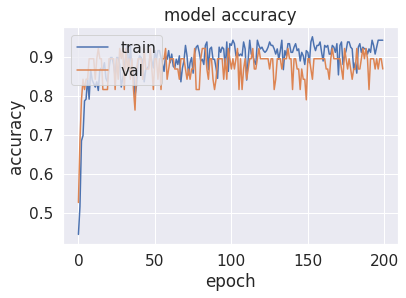

In [361]:
#Exactitud de entramiento y validación del modelo
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

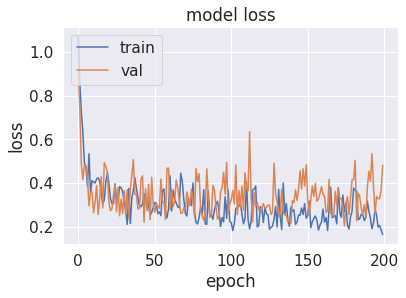

In [362]:
#Error de entramiento y validación del modelo
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

2/2 [==============================] - 0s 8ms/step


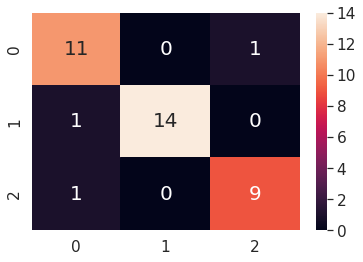

In [363]:
# Testear el modelo
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test, axis=-1)

# Definir la matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[0]))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 20})

plt.show()

In [364]:
# Definir la dirección donde se guardará los datos del modelo.
MODELS_DIR = 'models/'
MODEL_TFLITE = MODELS_DIR + 'model_no_quant.tflite'

# Crear la carpeta sino existe.
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)

# Guardar el modelo.
model.save(MODELS_DIR)

# Convertir el modelo a Tensorflow Lite.
converter = lite.TFLiteConverter.from_keras_model(model)
model_tflite = converter.convert()

# Guardar el modelo .tflite
open(MODEL_TFLITE, "wb").write(model_tflite)

# Correr esta linea de código en Linux.
# Esto se hace para transformar el modelo a un archivo fuente C (https://www.tensorflow.org/lite/microcontrollers/build_convert?hl=es-419#model_conversion)
# xxd -i converted_model.tflite > model_data.cc

68248

In [365]:
# Instantiate an interpreter for each model
exercice_model = tf.lite.Interpreter(MODEL_TFLITE)

# Allocate memory for each model
exercice_model.allocate_tensors()

# Get the input and output tensors so we can feed in values and get the results
input_details = exercice_model.get_input_details()[0]
output_details = exercice_model.get_output_details()[0]

test = 11

input_data = x_test[test]
exercice_model.set_tensor(0,[input_data])

exercice_model.invoke()
  
output_data = exercice_model.get_tensor(output_details['index'])
    
  
print(output_data)  
print(y_test[test])
    

[[0.00469086 0.87923765 0.1160714 ]]
[0. 1. 0.]


In [366]:
input_data = x_test[test]
input_data

array([0.18795595, 0.14449146, 0.2439908 , 0.13558106, 0.10273898,
       0.19547792, 0.13414505, 0.24594887, 0.14228472, 0.10260677,
       0.54215103, 0.65329355, 0.5771407 , 0.7703084 , 0.84925526,
       0.33309025, 0.603981  , 0.6075047 , 0.79409254, 0.8700505 ],
      dtype=float32)

In [367]:
input_data.shape

(20,)

In [368]:
input_details

{'name': 'serving_default_dense_70_input:0',
 'index': 0,
 'shape': array([ 1, 20], dtype=int32),
 'shape_signature': array([-1, 20], dtype=int32),
 'dtype': numpy.float32,
 'quantization': (0.0, 0),
 'quantization_parameters': {'scales': array([], dtype=float32),
  'zero_points': array([], dtype=int32),
  'quantized_dimension': 0},
 'sparsity_parameters': {}}

In [369]:
output_details

{'name': 'StatefulPartitionedCall:0',
 'index': 16,
 'shape': array([1, 3], dtype=int32),
 'shape_signature': array([-1,  3], dtype=int32),
 'dtype': numpy.float32,
 'quantization': (0.0, 0),
 'quantization_parameters': {'scales': array([], dtype=float32),
  'zero_points': array([], dtype=int32),
  'quantized_dimension': 0},
 'sparsity_parameters': {}}

In [370]:
import os
basic_model_size = os.path.getsize(MODEL_TFLITE)
print("Basic model is %d bytes" % basic_model_size)

Basic model is 68248 bytes


In [371]:

# Save the file as a C source file
!xxd -i /content/models/model_no_quant.tflite > model_data.cc
# Print the source file
!cat exercice_model.cc

unsigned char _content_models_model_no_quant_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x98, 0x00, 0x00, 0x00, 0xf0, 0x00, 0x00, 0x00, 0xb4, 0x01, 0x01, 0x00,
  0xc4, 0x01, 0x01, 0x00, 0x0c, 0x0a, 0x01, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 0x00, 0x00, 0x0a, 0x00,
  0x10, 0x00, 0x0c, 0x00, 0x08, 0x00, 0x04, 0x00, 0x0a, 0x00, 0x00, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x40, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x90, 0xff, 0xff, 0xff, 0x10, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x61, 0x63, 0x74, 0x69,
  0x76, 0x61, 0x74, 0x69, 0x6f, 0x6e, 0x5f, 0x32, 0x00